In [1]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from joblib import dump
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [8]:
train_df_raw = pd.read_csv('data/train_rosters.csv')
eval_df_raw = pd.read_csv('data/eval_rosters.csv')

In [9]:
train_df = train_df_raw.copy()
eval_df = eval_df_raw.copy()

train_df = train_df.fillna(-1)
eval_df = eval_df.fillna(-1)

print(train_df.shape)
train_df.head()

(1466873, 36)


,Unnamed: 0,index,num_workers,num_days,num_shifts,num_tracks,num_skills,staff_req_sparcity,staff_avail_sparcity,avg_num_skills_of_each_worker,...,deviations_skill_staffing_from_mean,diff_available_workers_and_staffing_req_across_shifts,diff_average_avail_workers_and_current_avail_workers,deviations_current_avail_workers_from_avg,max_possible_coverage,available_shifts_less_than_max,total_workers_required_to_fill_roster,avg_shifts_required_less_than_max,lpr_val,target
0,0,"[0, 0, 0, 0, 0]",12,4,6,3,3,0.057099,0.104167,1.0,...,-0.036,8,8.0,11.085,1.777027,False,148.0,True,0.000000e+00,0
1,1,"[0, 0, 0, 0, 1]",12,4,6,3,3,0.057099,0.104167,1.0,...,-0.036,8,8.0,11.085,1.777027,False,148.0,True,0.000000e+00,0
2,2,"[0, 0, 0, 0, 2]",12,4,6,3,3,0.057099,0.104167,1.0,...,-1.347,8,8.0,11.085,1.777027,False,148.0,True,0.000000e+00,0
3,3,"[0, 0, 0, 1, 0]",12,4,6,3,3,0.057099,0.104167,1.0,...,-1.347,7,7.0,9.699,1.777027,False,148.0,True,0.000000e+00,0
4,4,"[0, 0, 0, 1, 1]",12,4,6,3,3,0.057099,0.104167,1.0,...,0.619,7,7.0,9.699,1.777027,False,148.0,True,6.611818e-13,0


In [10]:
print("Before shape", train_df.shape)
train_df = train_df[train_df.worker_is_available==1]
print("After shape", train_df.shape)
print("Assignments", sum(train_df.target))

eval_df = eval_df[eval_df.worker_is_available==1]
print(eval_df.shape)

Before shape (1466873, 36)
After shape (1326681, 36)
Assignments 137552
(315292, 36)


In [29]:
def pop_features(df, features):
    for feat in features:
        df.pop(feat)

remove_features = ['Unnamed: 0', 'index',
                   "med_num_skills_of_each_worker", "avg_num_skills_of_each_worker",
                   "chi_num_skills_of_each_worker",
                   "diff_avg_skill_penalty_and_worker_penalty",
                   "local_skill_demand",
                   "deviations_skill_staffing_from_mean",
                   "num_days", 'num_workers', "staff_req_sparcity", "skill_scarcity"
                   ]
remove_features += ["max_possible_coverage",
"local_skill_rarity",
"total_workers_required_to_fill_roster",
"num_skills",
"num_shifts",
"avg_shifts_required_less_than_max",
"worker_is_available"]

remove_features += [
    "num_tracks",
"diff_skill_staffing_and_avg_skill_staffing",
"worker_skill_penalty_num_dev_from_mean",
"staffing_req",
"diff_available_workers_and_staffing_req_across_shifts",
]

#"diff_skill_staffing_and_avg_skill_staffing"

pop_features(train_df, remove_features)
pop_features(eval_df, remove_features)
print(train_df.head)


<bound method NDFrame.head of          staff_avail_sparcity  worker_skill_penalty  worker_max_avail  \
0                    0.104167                     0              23.0   
1                    0.104167                    10              23.0   
2                    0.104167                    10              23.0   
3                    0.104167                     0              23.0   
4                    0.104167                    10              23.0   
...                       ...                   ...               ...   
1466868              0.467532                     0              13.0   
1466869              0.467532                     0              13.0   
1466870              0.467532                     0              13.0   
1466871              0.467532                     0              13.0   
1466872              0.467532                     0              13.0   

         day_req_chi_value  shift_req_chi_value  \
0                      4.4             1.1

In [30]:
y_train = train_df.pop('target').values
y_eval = eval_df.pop('target').values

y_train =  np.ravel(y_train, order='C')
y_test =  np.ravel(y_eval, order='C')

X_train = train_df.values
X_test = eval_df.values

scaler = preprocessing.StandardScaler().fit(X_train)
X_train= scaler.transform(X_train)
X_test= scaler.transform(X_test)


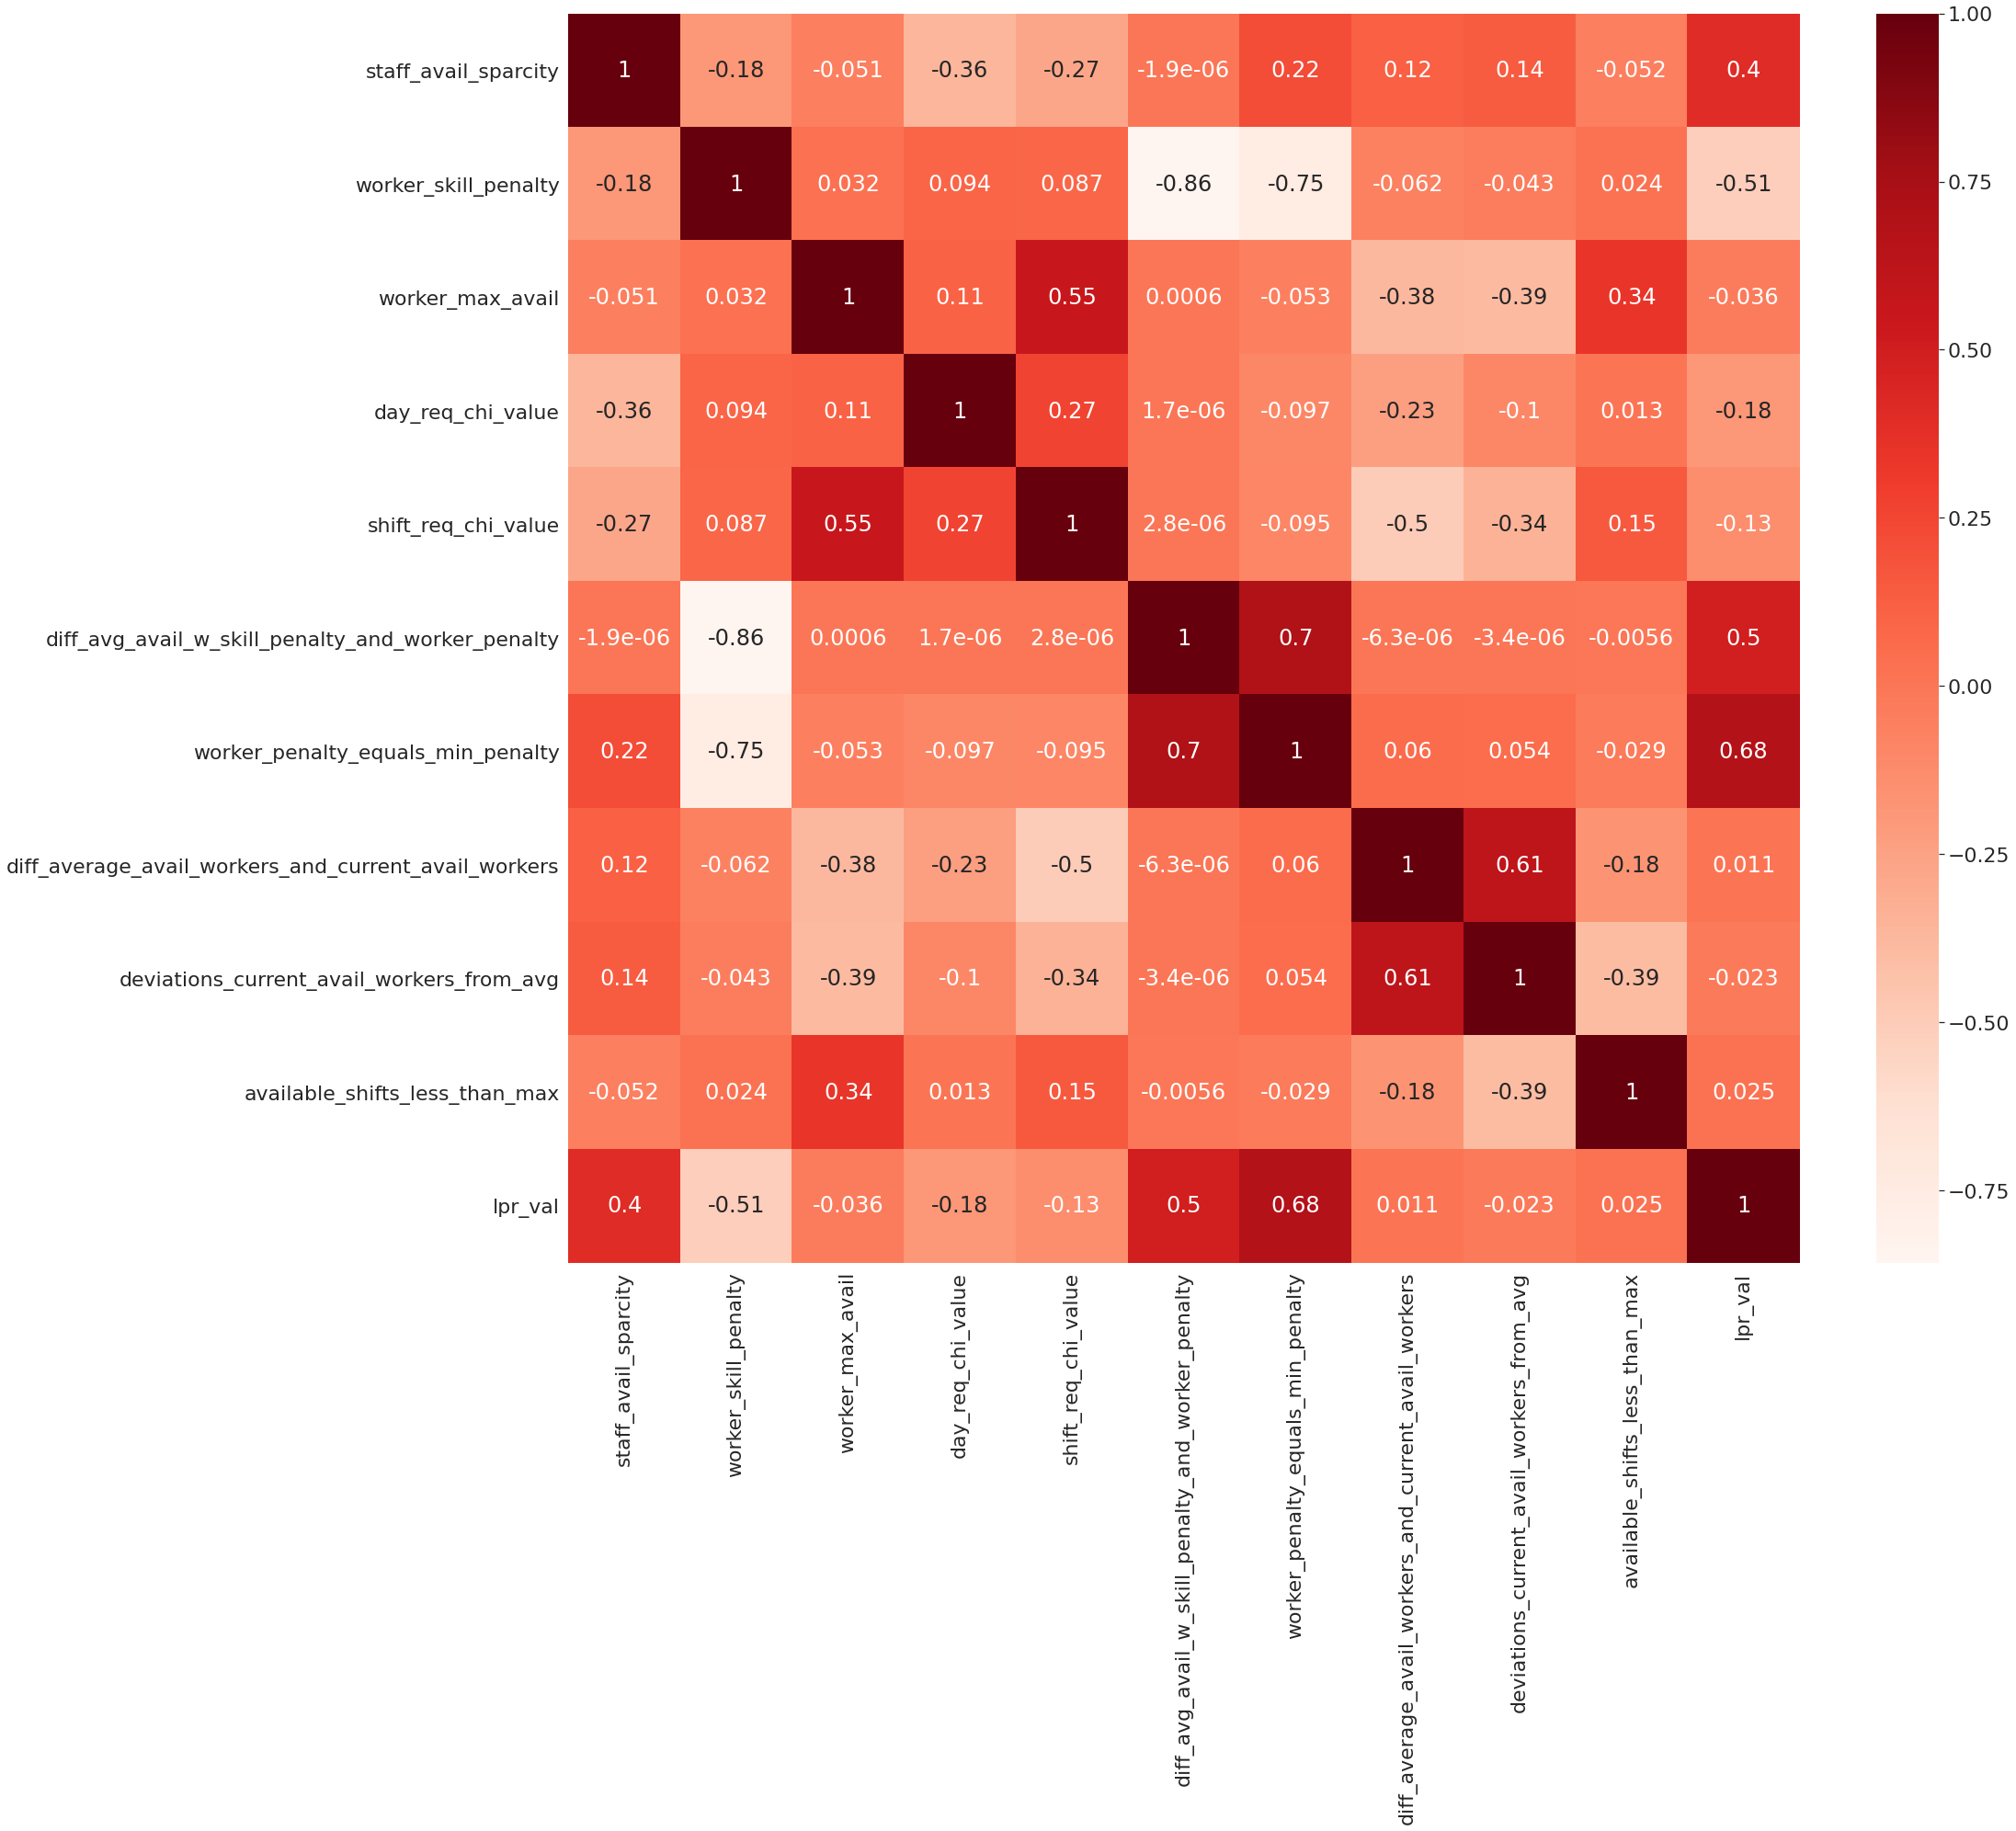

In [31]:
import seaborn as sns
#Using Pearson Correlation
sns.set(font_scale=2)
plt.figure(figsize=(30,25))
cor = train_df.corr()
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [32]:
figure = ax.get_figure()
figure.savefig('images/corelation.png')

In [33]:
i_scores = mutual_info_classif(X_train,y_train)
print(i_scores)

fs_df = pd.DataFrame(i_scores,index = train_df.columns, columns =['I-Gain'])
fs_df.sort_values(by=['I-Gain'],ascending=False,inplace=True)
print(fs_df)

[0.02758167 0.16944222 0.00761983 0.02403098 0.01964642 0.09008721
 0.20817218 0.00881806 0.02583207 0.12302842 0.21559603]
                                                      I-Gain
lpr_val                                             0.215596
worker_penalty_equals_min_penalty                   0.208172
worker_skill_penalty                                0.169442
available_shifts_less_than_max                      0.123028
diff_avg_avail_w_skill_penalty_and_worker_penalty   0.090087
staff_avail_sparcity                                0.027582
deviations_current_avail_workers_from_avg           0.025832
day_req_chi_value                                   0.024031
shift_req_chi_value                                 0.019646
diff_average_avail_workers_and_current_avail_wo...  0.008818
worker_max_avail                                    0.007620


In [34]:
rfc = RandomForestClassifier(random_state=0, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=0)

In [35]:
rf_df = pd.DataFrame(rfc.feature_importances_,index = train_df.columns, columns =['Importance'])
rf_df.sort_values(by=['Importance'],ascending=False,inplace=True)
print(rf_df)


                                                    Importance
lpr_val                                               0.507435
worker_penalty_equals_min_penalty                     0.127527
worker_skill_penalty                                  0.114443
diff_avg_avail_w_skill_penalty_and_worker_penalty     0.080852
worker_max_avail                                      0.051131
day_req_chi_value                                     0.030006
shift_req_chi_value                                   0.029978
staff_avail_sparcity                                  0.024580
deviations_current_avail_workers_from_avg             0.015224
diff_average_avail_workers_and_current_avail_wo...    0.013104
available_shifts_less_than_max                        0.005718


In [36]:
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return false_negative_rate(cm)

def fnr_complement_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return 1 - false_negative_rate(cm)

def fnr_prune_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)

    fnr =  false_negative_rate(cm)
    prune = prune_percentage(cm)
    return (1-fnr) + .25*prune


def false_negative_rate(cm):
    return round(cm[1][0] / (cm[1][0] + cm[1][1]), 3)

def negative_pred_val(cm):
    return round(cm[0][0] / (cm[0][0] + cm[1][0]), 3)

def prune_percentage(cm):
    return round( (cm[0][0] + cm[1][0]) / (np.sum(cm[:])), 3)

def print_metrics(clf):
    scores = cross_val_score(clf, X_test, y_test, cv=10, scoring='accuracy')
    print("Acc cv: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    scores = cross_val_score(clf, X_test, y_test, cv=10, scoring='f1_macro')
    print("F1 cv: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    #print("npr = ", negative_pred_val(cm))
    print("fnr = ", false_negative_rate(cm))
    print("prune = ", prune_percentage(cm))

def print_metrics_with_threshold(clf, threshold=0.85):
    y_pred_p = clf.predict_proba(X_test)

    y_pred_0 = np.where(y_pred_p[:,0] <= threshold, 0, y_pred_p[:,0])
    y_pred_1 = y_pred_p[:,1]

    y_pred = np.where(y_pred_0 > y_pred_1, 0, 1)

    cm = confusion_matrix(y_test, y_pred)
    fnr =  false_negative_rate(cm)
    prune = prune_percentage(cm)
    print("fnr = ", fnr)
    print("prune = ", prune)
    print("score = ", (1-fnr) + .25*prune)

def print_metrics_with_ranked_threshold(clf, threshold=5):
    num_assignments = int(sum(y_test) * threshold)

    print(num_assignments)


    y_pred_p = clf.predict_proba(X_test)
    y_pred_1 = y_pred_p[:,1]
    sorted_prob_assignments = sorted(y_pred_1, reverse=True)
    prob_cut_off = sorted_prob_assignments[num_assignments]
    print(prob_cut_off)


    y_pred_0 = np.where(y_pred_p[:,0] <= 1- prob_cut_off, 0, y_pred_p[:,0])
    y_pred_1 = y_pred_p[:,1]

    y_pred = np.where(y_pred_0 > y_pred_1, 0, 1)

    cm = confusion_matrix(y_test, y_pred)
    fnr =  false_negative_rate(cm)
    prune = prune_percentage(cm)
    print("fnr = ", fnr)
    print("prune = ", prune)
    print("score = " )

In [37]:
clf = SGDClassifier(max_iter=1000, tol=1e-3, loss='log', random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)
print_metrics_with_threshold(clf)

fnr =  0.007
prune =  0.495
score =  1.11675


In [38]:
sfs_forward = SFS(clf,
                  k_features=9,
                  forward=True,
                  floating=False,
                  scoring=fnr_complement_scorer,
                  cv=5, n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train, custom_feature_names=train_df.columns)

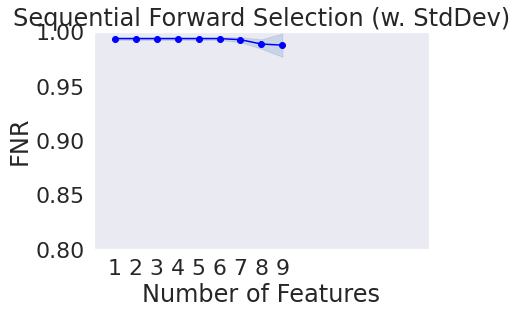

('staff_avail_sparcity', 'worker_skill_penalty', 'worker_max_avail', 'day_req_chi_value', 'shift_req_chi_value', 'worker_penalty_equals_min_penalty', 'diff_average_avail_workers_and_current_avail_workers', 'deviations_current_avail_workers_from_avg', 'available_shifts_less_than_max')


In [39]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(),
                ylabel='FNR',
                kind='std_dev')

plt.ylim([0.8, 1])
plt.xlim([0, 16])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.savefig('f_sfs_feature_acc.png')
plt.show()
print(sfs_forward.k_feature_names_)

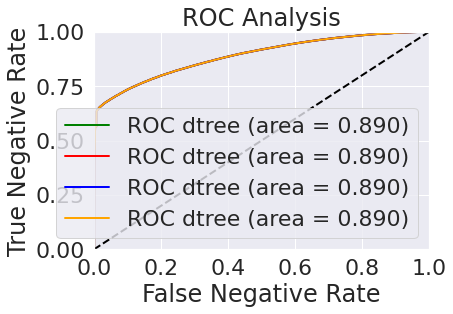

In [40]:
def roc(clf):
    y_score = clf.predict_proba(X_test)
    fpr, tpr, t = roc_curve(y_test, y_score[:,0], pos_label=0)
    roc = auc(fpr, tpr)

    return {"roc": roc, "fpr": fpr, "tpr": tpr}

roc_1 = roc(clf)
roc_2 = roc(clf)
roc_3 = roc(clf)
roc_4 = roc(clf)



%matplotlib inline
plt.figure()
lw = 2
plt.plot(roc_1['fpr'], roc_1['tpr'], color='green',
         lw=lw, label='ROC dtree (area = %0.3f)' % roc_1['roc'])
plt.plot(roc_2['fpr'], roc_2['tpr'], color='red',
         lw=lw, label='ROC dtree (area = %0.3f)' % roc_2['roc'])
plt.plot(roc_3['fpr'], roc_3['tpr'], color='blue',
         lw=lw, label='ROC dtree (area = %0.3f)' % roc_3['roc'])
plt.plot(roc_4['fpr'], roc_4['tpr'], color='orange',
         lw=lw, label='ROC dtree (area = %0.3f)' % roc_4['roc'])


plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Negative Rate')
plt.ylabel('True Negative Rate')
plt.title('ROC Analysis')
plt.legend(loc="lower right")
plt.savefig('out.png')
plt.show()



In [41]:
assert False
sfs_forward = SFS(clf,
                  k_features=10,
                  forward=True,
                  floating=False,
                  scoring=fnr_prune_scorer,
                  cv=10, n_jobs = -1)

sfs_forward = sfs_forward.fit(X_train, y_train, custom_feature_names=train_df.columns)


AssertionError: 

In [ ]:
do_sfs = False
if do_sfs:
    from sklearn.feature_selection import SequentialFeatureSelector
    clf = BernoulliNB()
    X_scaled = scaler.transform(X)
    #SequentialFeatureSelector(estimator=GaussianNB,)

    sfs_forward_gnb = SFS(clf,
                      k_features=34,
                      forward=True,
                      floating=False,
                      scoring=fnr_complement_scorer,
                      cv=10, n_jobs = -1)

    sfs_forward_gbb = sfs_forward_gnb.fit(X_scaled, y, custom_feature_names=df.columns)


In [ ]:
if do_sfs:
    from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
    import matplotlib.pyplot as plt

    fig1 = plot_sfs(sfs_forward_gnb.get_metric_dict(),
                    ylabel='FNR',
                    kind='std_dev')

    plt.ylim([0.5, 1])
    plt.xlim([0, 34])
    plt.title('Sequential Forward Selection (w. StdDev)')
    plt.grid()
    plt.savefig('f_sfs_feature_acc.png')
    plt.show()
    print(sfs_forward_gnb.k_feature_names_)


In [ ]:
#if do_sbs:
#    sfs_backward_test = SFS(gnb,
#                      k_features=1,
#                      forward=False,
#                      floating=False,
#                      scoring='f1',
#                      cv=10, n_jobs = -1)
#
#    clf_test = Pipeline([
#        ('feature_selection', sfs_backward_test),
#        ('classification', gnb)])
#    clf_test.fit(X, y)
#    clf_test.score(X,y)
#
##%%
#
#if do_sbs:
#    fig1 = plot_sfs(sfs_backward_test.get_metric_dict(), kind='std_dev')
#
#    plt.ylim([0, 1])
#    plt.xlim([0, 20])
#    plt.title('Sequential Backwards Selection (w. StdDev)')
#    plt.grid()
#    plt.savefig('b_sfs_feature_acc.png')
#    plt.show()
#